This notebook implements value iteration on GPU.  We then use this implementation to study the effects of positive and negative rewards in a Markov Decision Process (MDP) to better understand the nature of MDPs.  These observations were what led me to create the FastMDP algorithm described in my Master's Thesis:

https://lib.dr.iastate.edu/etd/17832/

This notebook assumes the reader has some familiarity with Markov Decision Processes and the Value Iteration algorithm.   An overview is provided, but there are many good textbooks and resources that explain MDPs more fully and more clearly.

*Note that to run this notebook on Colab, you will need to change the Runtime to a GPU runtime.  Depending on the amount of RAM used by the run, you may also find you need a Google Colab Pro account and run with the higher RAM option.*

*Note that on my PC, in order to run this notebook I had to shutdown all the other notebooks because this notebook could not obtain enough GPU memory.  If you receive a CUDA memory allocation error from Numba, try doing that.*

# MDP and Value Iteration Background

A Markov Decision Process is described as the tuple:

$M = (S, A, T, R)$ where:

  * $s \in S$ are the states that represent where the agent can be in the environment
  * $a \in A$ are the actions that can be taken by the agent at some state $s \in S$
  * $T( s, a, s' )$ is the transition function which describes the probability $p( s' | s, a )$ of reaching next state $s' \in S$ after taking action $a \in A$ from state $s \in S$
  * $R$ is known as the reward function and describes how the agent receives reward from the enviornment.  In the most basic form, $R(s)$ is the reward received for reaching state $s$.  More formally, $R( s, a )$  is the immediate reward $r$ received for taking action $a \in A$ from state $s \in S$.  Note that the $R( s )$ formulation is equivalent to $R( s, a )$ when the immediate reward is the same regardless of action, or $\forall s \in S, R(s, a_i) = R(s, a_j), i \neq j$.  


## Deterministic vs Stochastic
Note that an MDP is said to be "deterministic" in cases where an action always results in a known transition with no uncertainty or randomness (that is $\forall s, a:  \exists s' ~ T( s, a, s' ) = 1.0$ and $\sum_{s'} T(s, a, s' ) = 1.0$.)  This means that one transition happens with probabiity 1.0 and all other probabilties are 0.0.

In contrast, an MDP is said to be "stochastic" when taking an action has some element of randomness in which next state $s'$ you will end up in.  In these cases, $\sum_{s'} T(s, a, s') = 1.0$.

## Policy
A "policy" $\pi(s) \in \Pi$ is defined over an MDP and provides a mapping from a state $s \in S$ to a prescribed action $a \in A$ that will be taken from that state.  The policy essentially defines the response of the agent no matter where the agent finds itself in the state space.  

## Value Function
When exeucting the policy $\pi \in \Pi$, the future expected reward at each state $s \in S$ can be computed as an expectation of the immediate reward obtained for taking the action $a = \pi(s)$ iteratively by applying the following recursive relation known as the Bellman update.  This future expected reward is known as the "value" of the state and is denoted $V(s)$.

$V(s) = {\rm I\kern-.3em E}[ R( s, a ) + \gamma \cdot T( s, a, s' ) \cdot V( s' ) ]$,

where ${\rm I\kern-.3em E}$ is an expectation taken over all $s$, $a$, and $s'$, $\gamma \in (0.0, 1.0)$ is known as the "discount factor". 
Gamma serves to balance short term reward versus long term reward.  Small values of $\gamma$ encourage short term rewards and large values of $\gamma$ encourage long term rewards.  (This is known as the "infinite horizon" formulation, but we won't get into that in any more detail here.)

## Value Iteration Overview
The Value Iteration algorithm computes the value function by multiple iterations of applying the Bellman update at each state in the state space. 

$V(s) = r + \gamma \max_{a \in A} \sum_{s' \in S} T( s, a, s' ) \cdot V(s')$

The Bellman update essentially says that the value of the current state is the immediate reward, $r$, plus the future discounted reward of the best possible action that can be taken.  $\gamma$ is responsible for discounting future reward.  We perform a $\max$ over all possible actions.  For each action, we compute an expected value by computing a sum over the possible reachable states $s'$ weighted by the probability of reaching state $s'$ (which may be zero for some combinations of $(s, s')$.)


Each pass through the states in the state space yield a value function that is successively closer to the optimal value function, and the algorithm terminates when the difference between successive updates of the value function falls below some threshold $\epsilon$ known as the Bellman residual.  (We won't get into it here, but the Bellman update process, also known as the Bellman operator $V' = LV$, has been shown to be a contractive mapping and will converge to the true optimal value function $V^* = LV^*$ which is a fixed-point solution.)

This algorithm yields an "exact" result (at least to the $\epsilon$ Bellman residual threshold) and is guaranteed to converge but has two major disadvantages:

1. It may take many, many iterations to converge
2. It requires a table in memory to represent the value function that is the size of the state space $|S|$.

For toy problems, neither of these represent too much of an issue.  However, practical problems typically have state spaces that are very large and the size of the state space tends to grow exponentially.  In practice, very few useful MDPs can fit in memory unless the problem structure allows for a clever representation of the state space.  Other methods have been developed to address many of the shortcomings of Value Iteration, but it is still a very useful algorithm for studying MDPs.

Additionally, a naive implementation of the transition function and reward functions might also choose to represent these as tables in memory.  The transition function is of size $|S| \times |A| \times |S|$ and the reward function is of size $|S| \times |A|$ (assuming R(s,a) formulation).  However, the reward and transition functions often have some pattern or mathematical formula that can represent them and need not always be captured in table form.  (Note that in this notebook, we do use this naive representation of the reward and transition function because it is easier, and because we are working with small MDPs that can fit into memory easily.)






# GPU 

GPUs allow multiple operations to be performed in parallel.  A GPU can be thought of as having thousands of simple CPUs that run very simple programs at the same time.  Usually, each one of these simple programs operates on a small portion of a data set.  For algorithms which perform the same operation over and over on different parts of the data set, GPUs can provide an enormous benefit.

For example, images can be broken down into pixels and each pixel has usually 3 color channels to represent red, green, and blue.  If we think of this as a large array in memory, we might want to write an algorithm that removes all blue from an image.  We could write a program on a CPU that loops over each array element that sets the blue pixel value to 0, where 1 thread iterates over and over on different elements of the array.  

In contrast, on a GPU we might instead launch one thread per pixel where each thread sets the blue pixel value to 0 for only that pixel.  Note that if there are many pixels in the image, this might mean we launch millions of threads.  On a CPU, this might be disastrous as that many threads would have too much overhead to be efficient due to the complexity of the CPU and how it must keep track of threads.  GPUs in contrast are much simpler processors and there is comparatively very little overhead with having enormous numbers of threads.  We describe a problem as "embarrasingly parallel" when each of these threads has very little or no dependency on the operation of other threads.  Because each of our threads is just zeroing out the blue portion of its designated pixel and the thread isn't dependent on the solution provided by any other thread, our example is embarrasingly parallel.

The Value Iteration algorithm is an algorithm that operates iteratively where each iteration gets successively closer and closer to calculating the Optimal Value Function for a Markov Decision Process (MDP).  Within each iteration, a calculation is performed for each state in the state space.  This is very similar to an image with pixels where in this analogy, each state of the state space corresponds to a pixel in an image.  The computation performed on each state in the state space is also very simple and has no dependencies on the results produced by calculations performed on other states, and is therefore also an embarrasingly parallel problem.

This notebook takes advantage of this property of Value Iteration to implement a version of Value Iteration suitable for a GPU.  Note that there are multiple vendors of GPUs and that normally each vendor has their own API for programming the GPU.  The GPUs used on Google Colab are currently (as of the time of this writing) NVIDA GPUs which use an API known as NVIDIA CUDA.  A python library called numba provides some convenient python-based wrappers that use just-in-time compiling to generate GPU code on the fly.  This notebook uses numba's CUDA wrappers to implement the algorithm.  In principle this code could easily be adapted to a native C++ CUDA API without difficulty.  

# Preliminaries

In [9]:


import numpy as np
import operator


import matplotlib.pyplot as plt


import IPython.display as dp
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec 

import time

import numba as nb

from timeit import default_timer as timer

Let's rewrite value iteration as a GPU algorithm.  This is a deterministic transition function.  Actions in this code are hard coded to up, down, left, right.


# Deterministic MDP with Arbitrary Transition Function

Here's a reimplemenation of the above that allows an arbitrary transition function to be specified.  Here we build up a transition function that is equivalent to the hard coded one above.

## Version 2 of code

In [10]:
#%load_ext autoreload
#%autoreload 2

#import os
#os.environ["NUMBA_ENABLE_CUDASIM"] = ""
#del os.environ["NUMBA_ENABLE_CUDASIM"]

import numpy as np
import math

import numba
from numba import cuda

@cuda.jit
def bellman_update_st(xmax, ymax, V_i, V_o, T_gpu, R_gpu, residual_gpu, gamma):
    
    num_actions = T_gpu.shape[2]  # assumes 2-d state space definition

    x, y = cuda.grid( 2 )

    #print( "pos %d -> x %d, y %d" % (pos, x, y ) ) 
    if x >= xmax:
      return

    if y >= ymax:
      return


    # immediate reward
    r = R_gpu[ x, y ]

    # bellman update for stochastic mdp

    # first we have to compute the future expected value of taking
    # an action from this state.  We will keep track of the best
    # value we find in max_V.

    max_V = -np.inf

    # There is some additional parallelism we could take advantage of in here
    # if we'd like to kick off additional threads in parallel.  This will
    # get tricky because we'll need to either use atomic sum operations
    # or we'll need to build a pipeline of kernels to perform a reduction.
    # For now, performing the loop below on each thread, which will make
    # the algorithm slower than it could be on the GPU.
    for a in range(num_actions):

      # We have to sum up over all s' the expected future values
      V_sum = 0

      for xn in range(xmax):
        for yn in range(ymax):

          # probability of transitioning to the next state given
          # the current state and action
          P_n = T_gpu[ x, y, a, xn, yn ]

          # value of next state
          V_n = V_i[ xn, yn ]

          # expected future value of this transition
          V_sum += P_n * ( r + gamma * V_n )
      
      max_V = max( max_V, V_sum )

    # residual 
    res = abs(max_V - V_i[ x, y ])

    # update the value 
    V_o[ x, y ] = max_V

    # atomically update the residual
    cuda.atomic.max( residual_gpu, 0, res ) 
    


def numba_value_iteration_st(dims, V, T, R, epsilon, gamma):
    # Move data to GPU so we can do two operations on it
    V_gpu_a = cuda.to_device(V)
    V_gpu_b = cuda.to_device(V)
    T_gpu = cuda.to_device(T)
    R_gpu = cuda.to_device(R)

    num_actions = T.shape[2]

    residual = np.array( [ -np.inf ], dtype=V.dtype )

    start = timer()    

    count = 0
    while count == 0 or ( residual[0] > epsilon ):  # and count < 100 ):

      # Set up a ping-pong between the two value function buffers
      # so that V_i (input) is fixed during the iteration and
      # V_o (output) is updated at each iteration.
      if count % 2 == 0:
        V_i = V_gpu_a
        V_o = V_gpu_b
      else:
        V_i = V_gpu_b
        V_o = V_gpu_a

      # reset residual for next run
      residual[0] = -np.inf
    
      residual_gpu = cuda.to_device( residual )

      end1 = timer()

      num_threads = dims[0] * dims[1]
      threadsperblock = (16, 16)
      blockspergrid_x = math.ceil(dims[0] / threadsperblock[0])
      blockspergrid_y = math.ceil(dims[1] / threadsperblock[1])
      blockspergrid = (blockspergrid_x, blockspergrid_y)      

      ### Perform Bellman upate
      bellman_update_st[blockspergrid,threadsperblock](dims[0], dims[1], V_i, V_o, T_gpu, R_gpu, residual_gpu, gamma)

      end2 = timer()

      residual = residual_gpu.copy_to_host()

      end3 = timer()

      #print( "count %d: %f - %f secs (%f + %f + %f)" % (count, residual[0], end3 - start, end1 - start, end2-end1, end3-end2) )
      start = end3

      #np.save( 'val_iter/hist_%d.npy' % count, V_gpu.copy_to_host() )

      count += 1 


    return V_o.copy_to_host()



In [11]:
# Bellman residual
epsilon = .1

In [12]:
# Discount factor
gamma = 0.99

# Contours


(100, 100) 10000
Building transition function


/home/bertrjr1/anaconda3/envs/gpu2/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (49) < 2 * SM count (92) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/bertrjr1/anaconda3/envs/gpu2/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (49) < 2 * SM count (92) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


<a list of 8 text.Text objects>

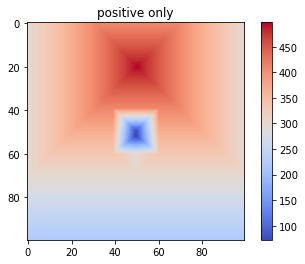

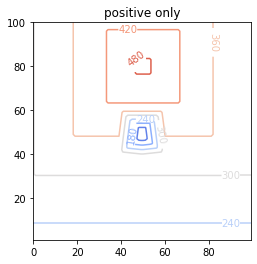

In [13]:
# The dimensions of the state space S is captured by dims.  
# Multiplying the dimensions together would yield the size of the
# state space |S|.
dim = 100
dims = (dim,dim)  # square grid world
size = np.prod( dims )

print( dims, size )

# The value function is the same size as the state space
V = np.zeros( dims )

# Our action space is N, S, E, W, NW, NE, SE, SW. If we were to go beyond
# the boundaries of the state space by taking an action 'a', then 
# will will just stay in the current state 's'.
num_actions = 8

# The transition function is T( s, a, s' ).
T = np.zeros( (*dims, num_actions, *dims)  )

def gen_nbrs(x,y):
    nbrs = []

    for dx in [ -1, 0, 1 ]:
      for dy in [ -1, 0, 1 ]:

        if dx == 0 and dy == 0:
          continue
        
        newx = x + dx
        newy = y + dy

        newx = max(        0, newx )
        newx = min( xmax - 1, newx )

        newy = max(        0, newy )
        newy = min( ymax - 1, newy )

        nbrs.append( [ newx, newy ] )
  
    return nbrs


print( "Building transition function" )
# Create a stochastic transition function for up, down, left, and right
# where there is uncertainty in the resulting state
xmax = ymax = dim
for x in range(dim):
  for y in range(dim):

    nbr = gen_nbrs( x, y )

    # When we take an action, set a probability of 0.6 that we'll make it 
    # to the desired state
    for a, n in enumerate(nbr):
      xn, yn = n
      T[ x, y, a, xn, yn ] = 1.0

      # And set a probability of 0.1 that we will end up one extra step
      # away from the expected state were this a deterministic MDP.  
      # This is a poor man's gaussian centered around the expected state.
      nbr2 = gen_nbrs( xn, yn )

      for n2 in nbr2:
        xn2, yn2 = n2 
        T[ x, y, a, xn2, yn2 ] = 0.0

# For now, we are creating a reward function R( s ) which is only
# dependent on the state but not the action.
R = np.zeros( dims )

# define some rewards in the reward function
R[ 20,50 ] = 10

R[ 40:60,40:60 ] = -30

V_p = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )

plt.figure()
plt.title( "positive only")
plt.imshow( V_p, cmap="coolwarm" )
plt.colorbar()

x = np.arange(0.0, dim)
y = np.arange(dim, 0.0, -1)
X, Y = np.meshgrid(x, y)

plt.figure()
ax =plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.title( "positive only")
CS = ax.contour( X, Y, V_p, cmap="coolwarm" )
ax.clabel(CS, inline=True, fontsize=10)


In [14]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D

def solve_and_plot_contours( dims, V, T, R, epsilon, gamma ):

  V_p = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )

  fig = plt.figure(figsize=(24,6), constrained_layout=False)
  gs = fig.add_gridspec(1,4)

  ax = fig.add_subplot(gs[0, 0] )
  plt.title( "Reward function (top view)")
  plt.imshow( R, cmap="coolwarm" )
  plt.colorbar()

  ax = fig.add_subplot(gs[0, 1] )
  plt.title( "Value function (top view)")
  plt.imshow( V_p, cmap="coolwarm" )
  plt.colorbar()

  x = np.arange(0.0, dim)
  y = np.arange(dim, 0.0, -1)
  X, Y = np.meshgrid(x, y)

  ax = fig.add_subplot(gs[0, 2] )
  ax.set_aspect('equal', adjustable='box')
  plt.title( "Value function contour plot (top view)")
  CS = ax.contour( X, Y, V_p, cmap="coolwarm" )
  ax.clabel(CS, inline=True, fontsize=10)

  V_o = V_p
  Z = V_o

  print( X.shape, V_o.shape )


  ax = fig.add_subplot(gs[0, 3], projection='3d')
  plt.title( 'Value function (3d view)')
  #plt.imshow( V_o, cmap="jet" )

  e=40
  a=-60

  ax.view_init(elev=e, azim=a)
  p = ax.plot_surface(X, Y, Z, cmap='coolwarm',
                        linewidth=0, antialiased=False)
  plt.colorbar(p)



In [15]:
def negative_disc( rwd_func, center, radius, rwd_value, additive=False ):
  cx, cy = center
  for x in range(rwd_func.shape[0]):
      for y in range(rwd_func.shape[1]):
        dist = np.sqrt( (cx-x)**2 + (cy-y)**2 )

        if dist <= radius:
          if additive:
            rwd_func[ x, y ] += rwd_value
          else:
            rwd_func[ x, y ] = rwd_value


(100, 100) (100, 100)


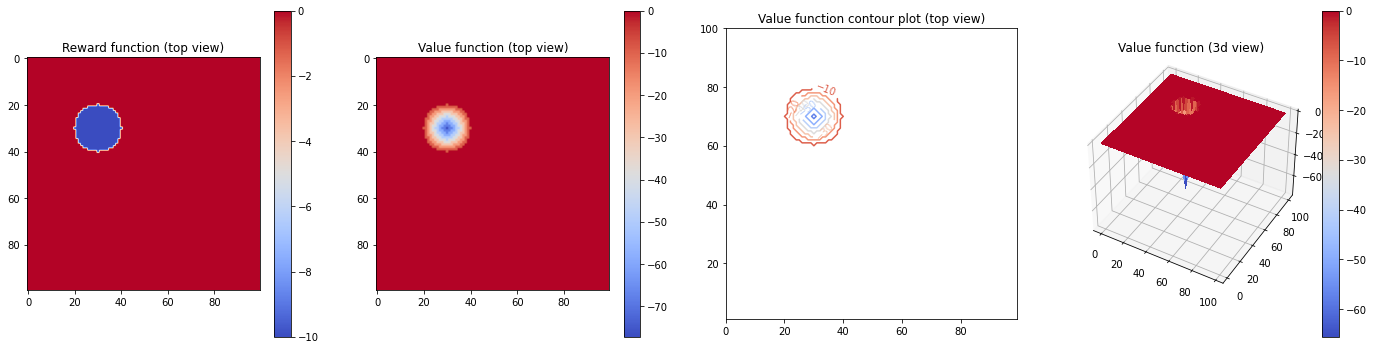

In [16]:
# For now, we are creating a reward function R( s ) which is only
# dependent on the state but not the action.
R = np.zeros( dims )

# define some rewards in the reward function
#R[ 20:40,20:40 ] = -30
negative_disc( R, center=[30,30], radius=10, rwd_value=-10 )

solve_and_plot_contours( dims, V, T, R, epsilon, gamma )

(100, 100) (100, 100)


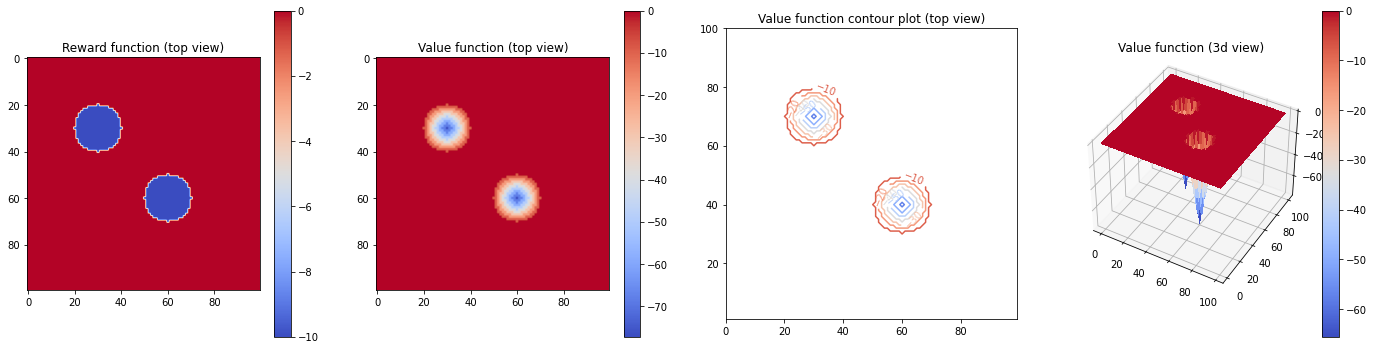

In [17]:
# For now, we are creating a reward function R( s ) which is only
# dependent on the state but not the action.
R = np.zeros( dims )

# define some rewards in the reward function
negative_disc( R, center=[30,30], radius=10, rwd_value=-10 )
negative_disc( R, center=[60,60], radius=10, rwd_value=-10 )
#R[ 20:40,20:40 ] = -10
#R[ 50:70,50:70 ] = -10

solve_and_plot_contours( dims, V, T, R, epsilon, gamma )

(100, 100) (100, 100)


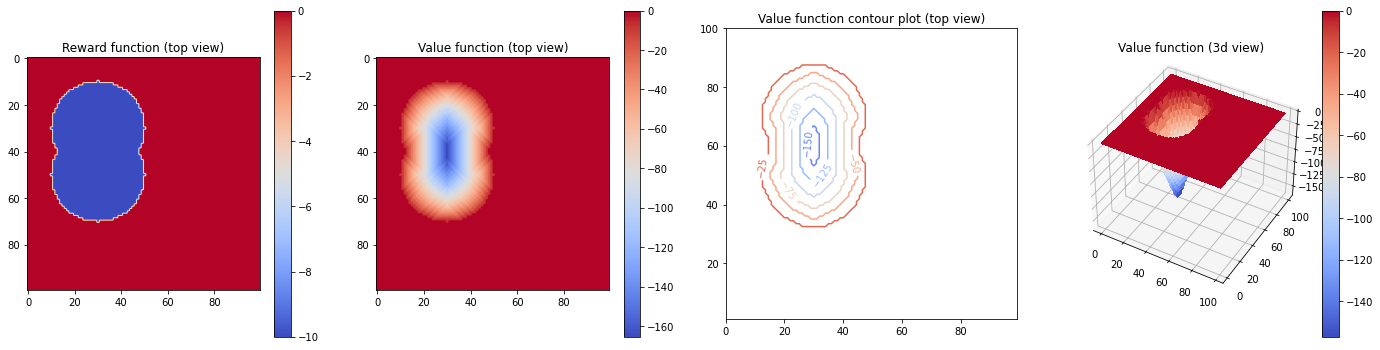

In [18]:
# For now, we are creating a reward function R( s ) which is only
# dependent on the state but not the action.
R = np.zeros( dims )

# define some rewards in the reward function
negative_disc( R, center=[30,30], radius=20, rwd_value=-10 )
negative_disc( R, center=[50,30], radius=20, rwd_value=-10 )


solve_and_plot_contours( dims, V, T, R, epsilon, gamma )

(100, 100) (100, 100)


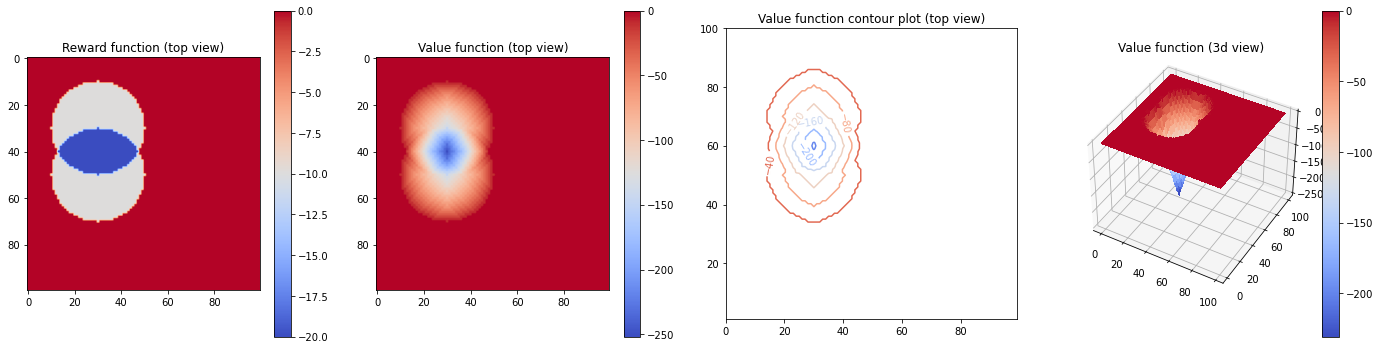

In [19]:
# For now, we are creating a reward function R( s ) which is only
# dependent on the state but not the action.
R = np.zeros( dims )

# define some rewards in the reward function
negative_disc( R, center=[30,30], radius=20, rwd_value=-10 )
negative_disc( R, center=[50,30], radius=20, rwd_value=-10, additive=True )


solve_and_plot_contours( dims, V, T, R, epsilon, gamma )

(100, 100) (100, 100)


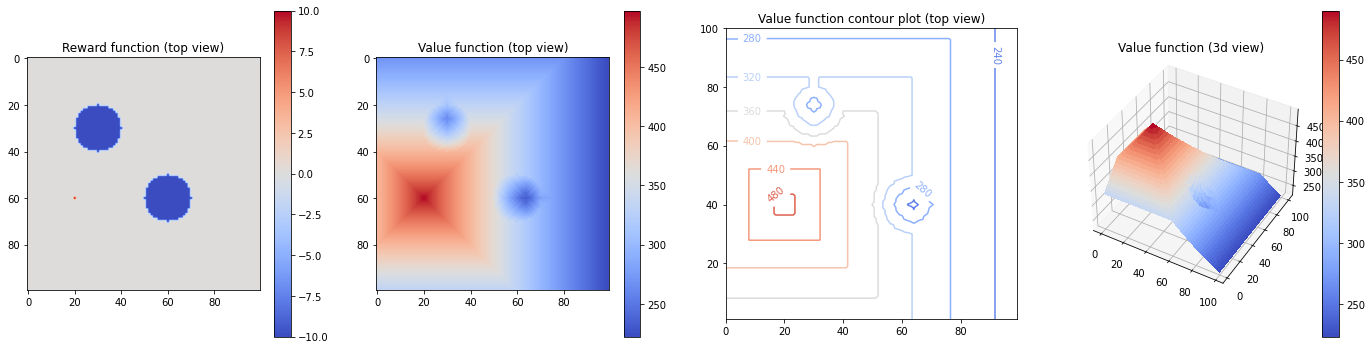

In [20]:
# For now, we are creating a reward function R( s ) which is only
# dependent on the state but not the action.
R = np.zeros( dims )

R[ 60, 20 ] = 10

# define some rewards in the reward function
negative_disc( R, center=[30,30], radius=10, rwd_value=-10 )
negative_disc( R, center=[60,60], radius=10, rwd_value=-10 )
#R[ 20:40,20:40 ] = -10
#R[ 50:70,50:70 ] = -10

solve_and_plot_contours( dims, V, T, R, epsilon, gamma )

In [21]:
def solve_and_plot_contours( dims, V, T, R, epsilon, gamma ):

  print( 'Solving MDP, epsilon', epsilon )
  V_p = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )
  print( 'Solved.' )

  fig = plt.figure(figsize=(24,6), constrained_layout=False)
  gs = fig.add_gridspec(1,4)

  ax = fig.add_subplot(gs[0, 0] )
  plt.title( "Reward function (top view)")
  plt.imshow( R, cmap="coolwarm" )
  plt.colorbar()

  ax = fig.add_subplot(gs[0, 1] )
  plt.title( "Value function (top view)")
  plt.imshow( V_p, cmap="coolwarm" )
  plt.colorbar()

  x = np.arange(0.0, dim)
  y = np.arange(dim, 0.0, -1)
  X, Y = np.meshgrid(x, y)

  ax = fig.add_subplot(gs[0, 2] )
  ax.set_aspect('equal', adjustable='box')
  plt.title( "Value function contour plot (top view)")
  CS = ax.contour( X, Y, V_p, cmap="coolwarm" )
  print( CS.labels )
  ax.clabel(CS, inline=True, fontsize=10)

  V_o = V_p
  Z = V_o

  print( X.shape, V_o.shape )


  ax = fig.add_subplot(gs[0, 3], projection='3d')
  plt.title( 'Value function (3d view)')
  #plt.imshow( V_o, cmap="jet" )

  e=40
  a=-60

  ax.view_init(elev=e, azim=a)
  p = ax.plot_surface(X, Y, Z, cmap='coolwarm',
                        linewidth=0, antialiased=False)
  plt.colorbar(p)

  return V_p


Solving MDP, epsilon 0.1
Solved.
<bound method ContourLabeler.labels of <matplotlib.contour.QuadContourSet object at 0x7ff005357a90>>
(100, 100) (100, 100)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


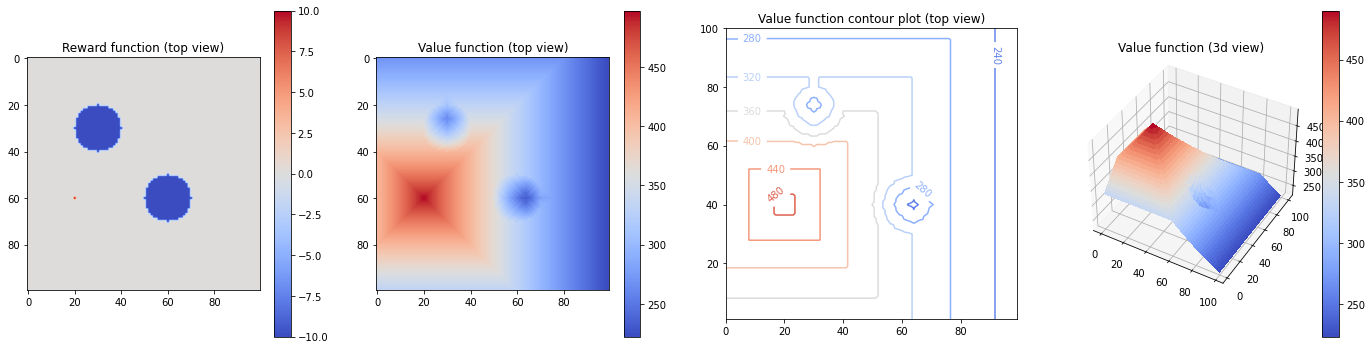

In [22]:
# For now, we are creating a reward function R( s ) which is only
# dependent on the state but not the action.
R = np.zeros( dims )

R[ 60, 20 ] = 10

# define some rewards in the reward function
negative_disc( R, center=[30,30], radius=10, rwd_value=-10 )
negative_disc( R, center=[60,60], radius=10, rwd_value=-10 )
#R[ 20:40,20:40 ] = -10
#R[ 50:70,50:70 ] = -10

if True:
  print( 'Solving MDP, epsilon', epsilon )
  V_p = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )
  print( 'Solved.' )

  fig = plt.figure(figsize=(24,6), constrained_layout=False)
  gs = fig.add_gridspec(1,4)

  ax = fig.add_subplot(gs[0, 0] )
  plt.title( "Reward function (top view)")
  plt.imshow( R, cmap="coolwarm" )
  plt.colorbar()

  ax = fig.add_subplot(gs[0, 1] )
  plt.title( "Value function (top view)")
  plt.imshow( V_p, cmap="coolwarm" )
  plt.colorbar()

  x = np.arange(0.0, dim)
  y = np.arange(dim, 0.0, -1)
  X, Y = np.meshgrid(x, y)

  ax = fig.add_subplot(gs[0, 2] )
  ax.set_aspect('equal', adjustable='box')
  plt.title( "Value function contour plot (top view)")
  CS = ax.contour( X, Y, V_p, cmap="coolwarm" )
  print( CS.labels )
  ax.clabel(CS, inline=True, fontsize=10)

  V_o = V_p
  Z = V_o

  print( X.shape, V_o.shape )


  ax = fig.add_subplot(gs[0, 3], projection='3d')
  plt.title( 'Value function (3d view)')
  #plt.imshow( V_o, cmap="jet" )

  e=40
  a=-60

  ax.view_init(elev=e, azim=a)
  p = ax.plot_surface(X, Y, Z, cmap='coolwarm',
                        linewidth=0, antialiased=False)
  plt.colorbar(p)

plt.savefig( 'future_deter_neg_circle.eps', format='eps', dpi=75 )

In [23]:
CS.labelCValueList


array([200., 240., 280., 320., 360., 400., 440., 480., 520.])

[200. 210. 220. 230. 240. 250. 260. 270. 280. 290. 300. 310. 320. 330.
 340. 350.]
[280. 285. 290. 295.]
[200.0, 240.0, 280.0, 320.0, 360.0, 400.0, 440.0, 480.0, 520.0, 200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 260.0, 270.0, 280.0, 290.0, 300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 280.0, 285.0, 290.0, 295.0]
[200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 260.0, 270.0, 280.0, 285.0, 290.0, 295.0, 300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 400.0, 440.0, 480.0, 520.0]


<a list of 31 text.Text objects>

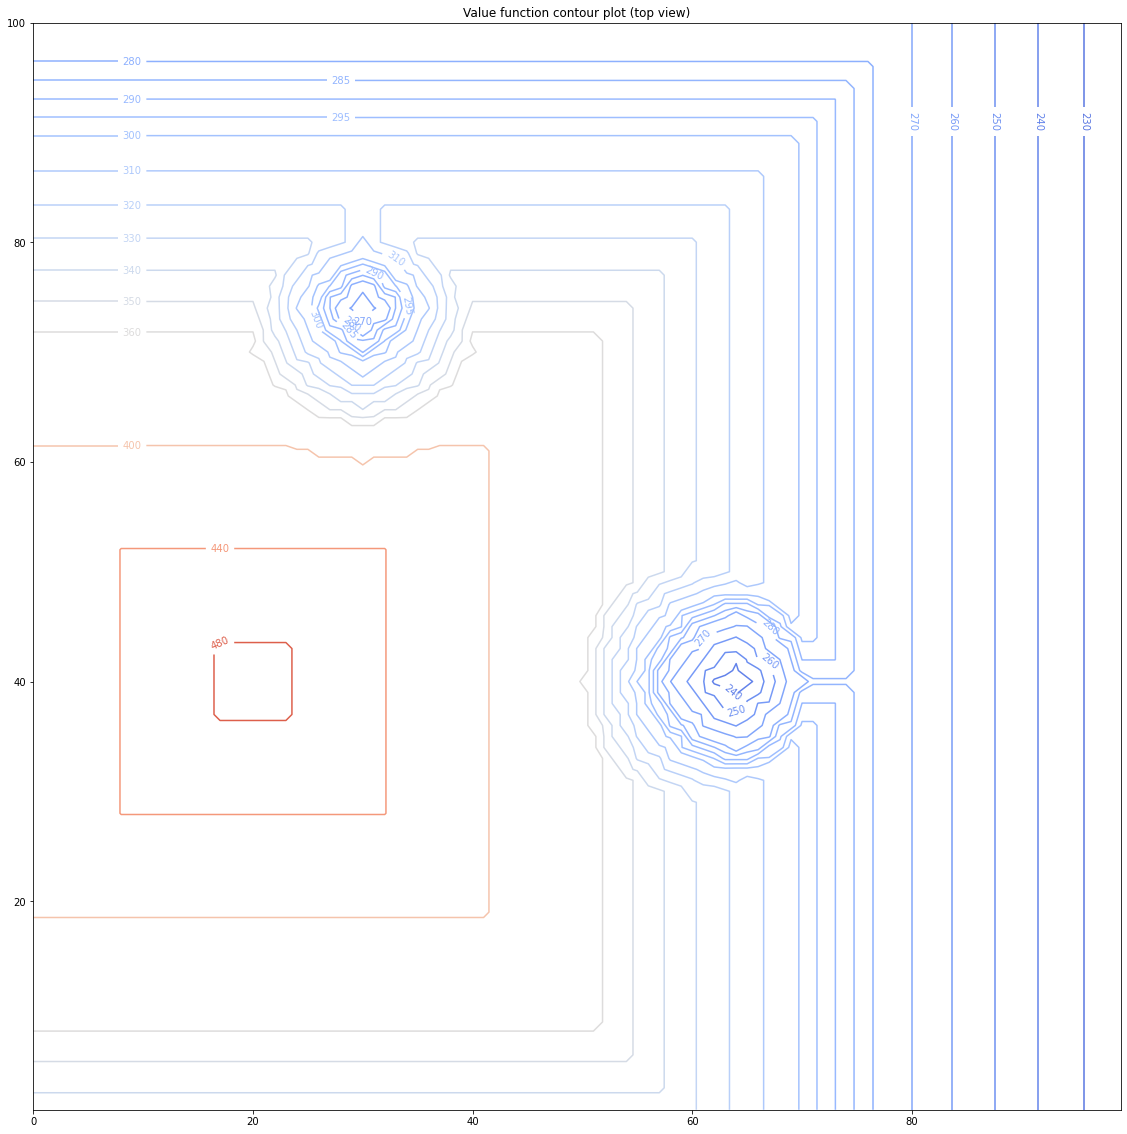

In [24]:
  fig = plt.figure( figsize=[20,20])
  ax = plt.gca()
  ax.set_aspect('equal', adjustable='box')
  plt.title( "Value function contour plot (top view)")
  minv = V_p.min()
  maxv = V_p.max()
  levels = [200., 240., 280., 320., 360., 400., 440., 480., 520.]
  extra_levels = np.arange( 200, 360, 10.0 )
  print( extra_levels )
  levels.extend( extra_levels )
  extra_levels = np.arange( 280, 300, 5.0 )
  print( extra_levels )
  levels.extend( extra_levels )
  print( levels )
  levels = list(sorted(np.unique(levels)))
  print( levels )
  CS = ax.contour( X, Y, V_p, levels = levels, cmap="coolwarm" )
  ax.clabel(CS, inline=True, fontsize=10)

In [25]:
CS.labelCValues


[230.0,
 240.0,
 240.0,
 250.0,
 250.0,
 260.0,
 260.0,
 270.0,
 270.0,
 270.0,
 280.0,
 280.0,
 280.0,
 285.0,
 285.0,
 290.0,
 290.0,
 295.0,
 295.0,
 300.0,
 300.0,
 310.0,
 310.0,
 320.0,
 330.0,
 340.0,
 350.0,
 360.0,
 400.0,
 440.0,
 480.0]

Solving MDP, epsilon 0.1
Solved.
<bound method ContourLabeler.labels of <matplotlib.contour.QuadContourSet object at 0x7ff00591f4c0>>
(100, 100) (100, 100)


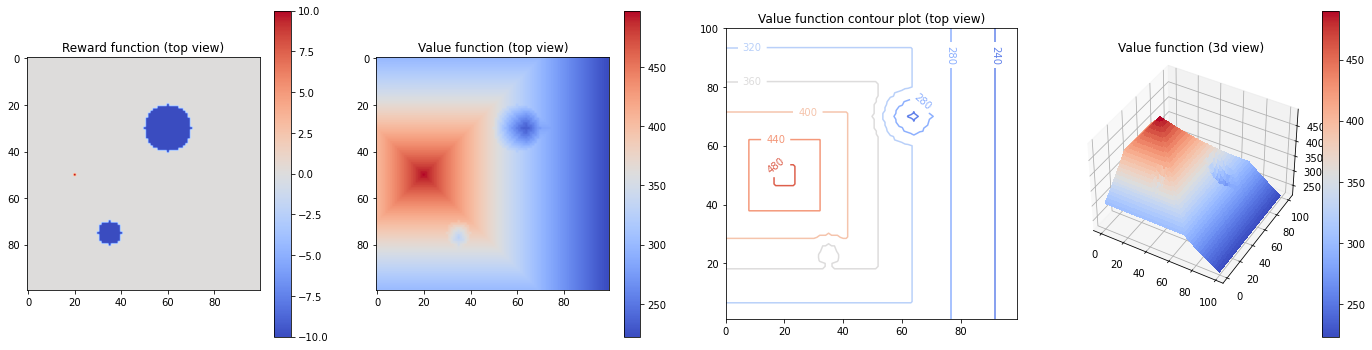

In [26]:
# For now, we are creating a reward function R( s ) which is only
# dependent on the state but not the action.
R = np.zeros( dims )

R[ 50, 20 ] = 10

# define some rewards in the reward function
negative_disc( R, center=[75,35], radius=5, rwd_value=-10 )
negative_disc( R, center=[30,60], radius=10, rwd_value=-10 )

if True:
  print( 'Solving MDP, epsilon', epsilon )
  V_p = numba_value_iteration_st( dims, V, T, R, epsilon, gamma )
  print( 'Solved.' )

  fig = plt.figure(figsize=(24,6), constrained_layout=False)
  gs = fig.add_gridspec(1,4)

  ax = fig.add_subplot(gs[0, 0] )
  plt.title( "Reward function (top view)")
  plt.imshow( R, cmap="coolwarm" )
  plt.colorbar()

  ax = fig.add_subplot(gs[0, 1] )
  plt.title( "Value function (top view)")
  plt.imshow( V_p, cmap="coolwarm" )
  plt.colorbar()

  x = np.arange(0.0, dim)
  y = np.arange(dim, 0.0, -1)
  X, Y = np.meshgrid(x, y)

  ax = fig.add_subplot(gs[0, 2] )
  ax.set_aspect('equal', adjustable='box')
  plt.title( "Value function contour plot (top view)")
  CS = ax.contour( X, Y, V_p, cmap="coolwarm" )
  print( CS.labels )
  ax.clabel(CS, inline=True, fontsize=10)

  V_o = V_p
  Z = V_o

  print( X.shape, V_o.shape )


  ax = fig.add_subplot(gs[0, 3], projection='3d')
  plt.title( 'Value function (3d view)')
  #plt.imshow( V_o, cmap="jet" )

  e=40
  a=-60

  ax.view_init(elev=e, azim=a)
  p = ax.plot_surface(X, Y, Z, cmap='coolwarm',
                        linewidth=0, antialiased=False)
  plt.colorbar(p)

### Looking at recovering value function with postive and negative



Solving MDP, epsilon 0.1
Solved.
<bound method ContourLabeler.labels of <matplotlib.contour.QuadContourSet object at 0x7ff0056f6c70>>
(100, 100) (100, 100)


array([[270.0175266 , 270.0175266 , 270.0175266 , ..., 226.88362844,
        224.51657452, 222.27140877],
       [272.8441861 , 272.8441861 , 272.8441861 , ..., 226.88362844,
        224.51657452, 222.27140877],
       [275.60018798, 275.60018798, 275.60018798, ..., 226.88362844,
        224.51657452, 222.27140877],
       ...,
       [341.57062264, 341.57062264, 341.57062264, ..., 226.88362844,
        224.51657452, 222.27140877],
       [338.05669877, 338.05669877, 338.05669877, ..., 226.88362844,
        224.51657452, 222.27140877],
       [334.67613178, 334.67613178, 334.67613178, ..., 226.88362844,
        224.51657452, 222.27140877]])

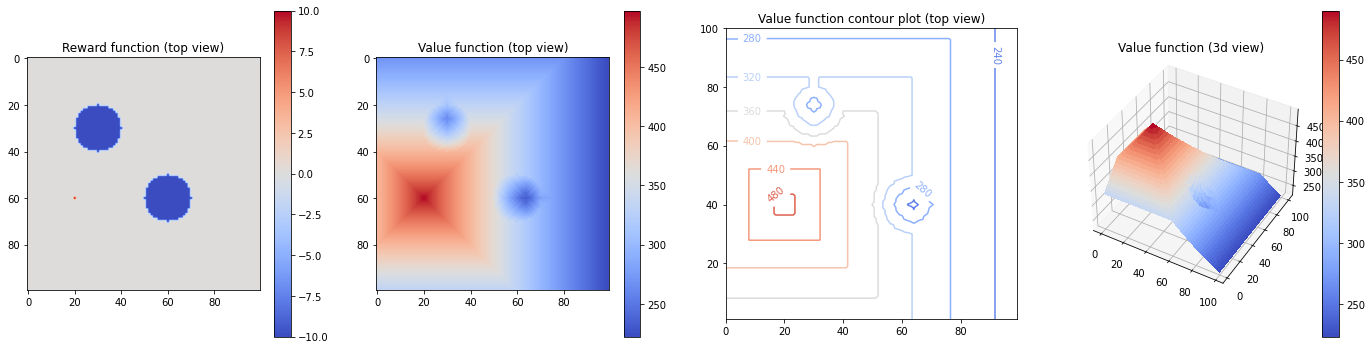

In [27]:
# For now, we are creating a reward function R( s ) which is only
# dependent on the state but not the action.
R = np.zeros( dims )

R[ 60, 20 ] = 10

# define some rewards in the reward function
negative_disc( R, center=[30,30], radius=10, rwd_value=-10 )
negative_disc( R, center=[60,60], radius=10, rwd_value=-10 )

solve_and_plot_contours( dims, V, T, R, epsilon, gamma )

Solving MDP, epsilon 1.0
Solved.
<bound method ContourLabeler.labels of <matplotlib.contour.QuadContourSet object at 0x7ff004e113a0>>
(100, 100) (100, 100)
Solving MDP, epsilon 1.0
Solved.
<bound method ContourLabeler.labels of <matplotlib.contour.QuadContourSet object at 0x7ff00c0f87c0>>
(100, 100) (100, 100)
Solving MDP, epsilon 1.0
Solved.
<bound method ContourLabeler.labels of <matplotlib.contour.QuadContourSet object at 0x7ff00c051820>>
(100, 100) (100, 100)


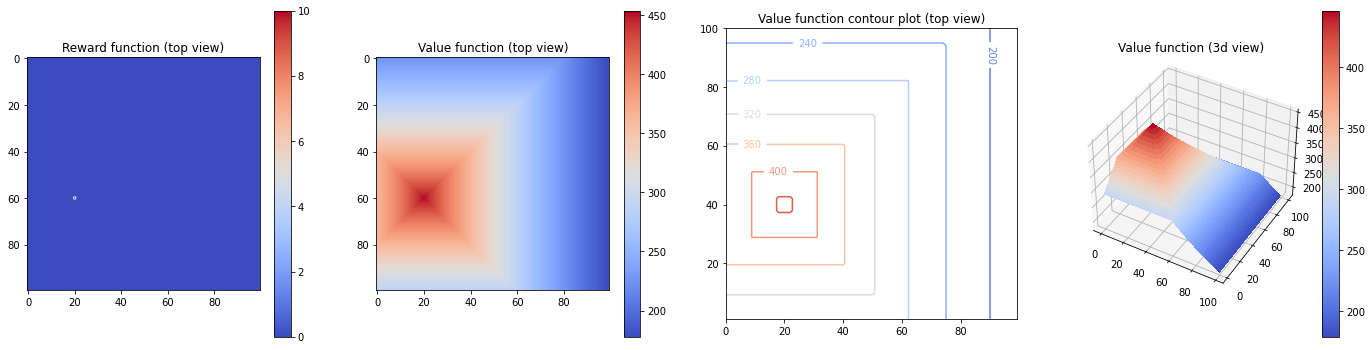

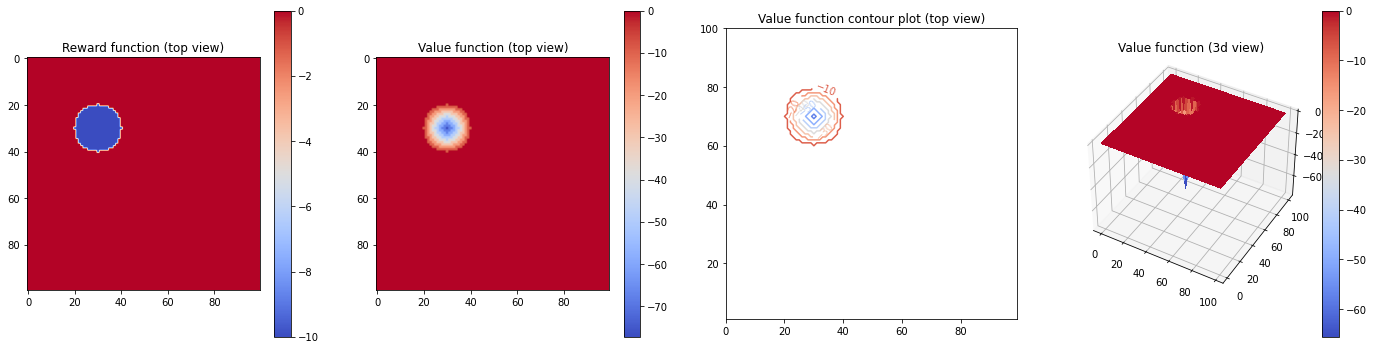

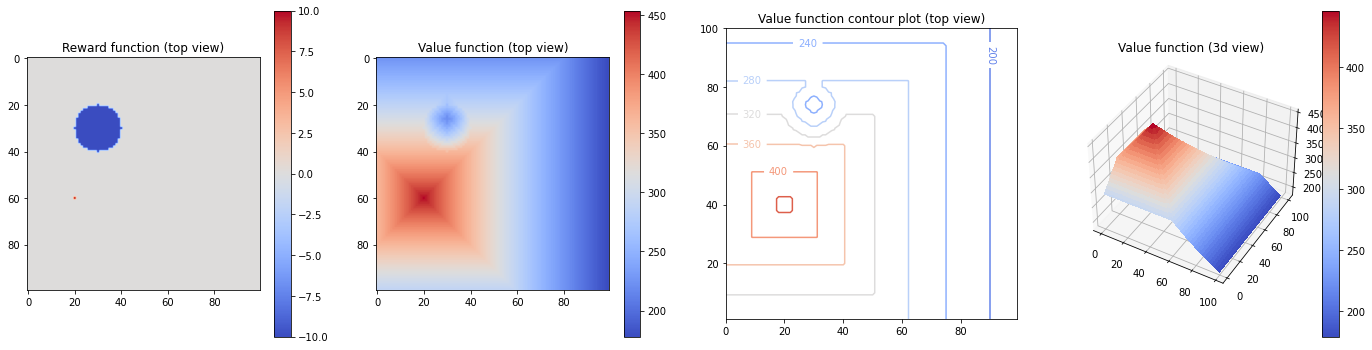

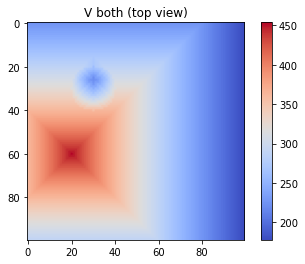

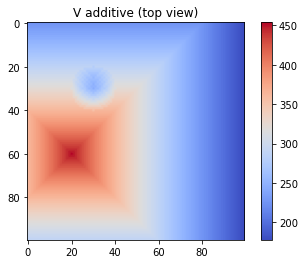

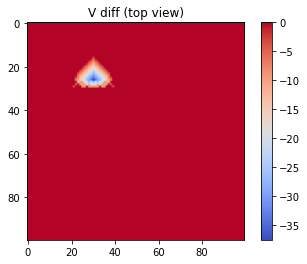

In [28]:
epsilon = 1.0

### Positive only
R = np.zeros( dims )
R[ 60, 20 ] = 10
V_pos = solve_and_plot_contours( dims, V, T, R, epsilon, gamma )

### Negative only
R = np.zeros( dims )
#R[ 60, 20 ] = 10
negative_disc( R, center=[30,30], radius=10, rwd_value=-10 )

V_neg = solve_and_plot_contours( dims, V, T, R, epsilon, gamma )

### Both
R = np.zeros( dims )
R[ 60, 20 ] = 10
negative_disc( R, center=[30,30], radius=10, rwd_value=-10 )

V_both = solve_and_plot_contours( dims, V, T, R, epsilon, gamma )


V_add = V_pos + V_neg

V_diff = V_both - V_add


plt.figure()
plt.title( "V both (top view)")
plt.imshow( V_both, cmap="coolwarm" )
plt.colorbar()

plt.figure()
plt.title( "V additive (top view)")
plt.imshow( V_add, cmap="coolwarm" )
plt.colorbar()

plt.figure()
plt.title( "V diff (top view)")
plt.imshow( V_diff, cmap="coolwarm" )
plt.colorbar()



In [29]:
R = np.zeros( dims )
R[ 60, 20 ] = 10
R_pos = R

R = np.zeros( dims )
negative_disc( R, center=[30,30], radius=10, rwd_value=-10 )
R_neg = R


R = np.zeros( dims )
R[ 60, 20 ] = 10
negative_disc( R, center=[30,30], radius=10, rwd_value=-10 )
R_both = R

R_add = R_pos + R_neg
R_diff = R_both - R_add

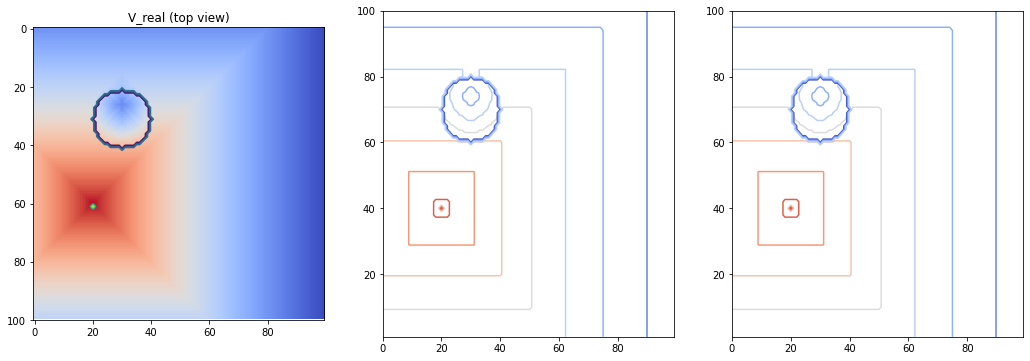

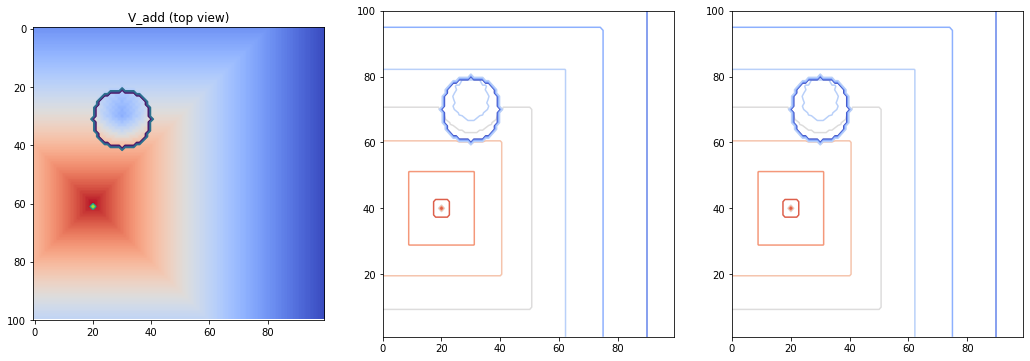

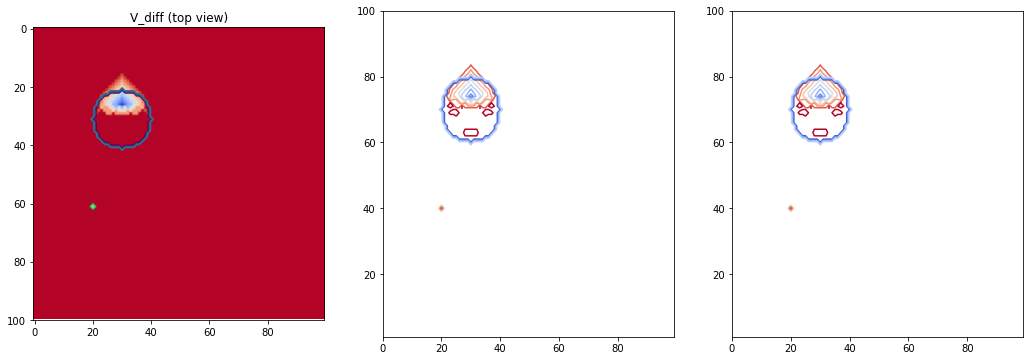

In [30]:
x = np.arange(0.0, dim)
y = np.arange(dim, 0.0, -1)
X, Y = np.meshgrid(x, y)

for v, name, r in [ [V_both, 'V_real', R_both],
                 [V_add,  'V_add',  R_add ],
                 [V_diff, 'V_diff', R_both ]
                ]:
  
  fig = plt.figure(figsize=(24,6), constrained_layout=False)
  gs = fig.add_gridspec(1,4)

  ax = fig.add_subplot(gs[0, 0] )
  plt.title( f"{name} (top view)")
  plt.imshow( v, cmap="coolwarm" )
  plt.contour( X, np.flip(Y), r ) 
  #plt.colorbar()

  ax = fig.add_subplot(gs[0, 1] )
  plt.contour( X, Y, v, cmap="coolwarm" )
  plt.contour( X, Y, r, cmap="coolwarm" )

  ax = fig.add_subplot(gs[0, 2] )
  plt.contour( X, Y, v, cmap="coolwarm" )
  plt.contour( X, Y, r, cmap="coolwarm" )




Man, the above is tricky.  It looks like the positive reward causes a warping of the negative reward well to make it off center??  